In [1]:
# Importing default Libraries
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
import warnings

# Hi-resolution Plots and Matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Set the maximum number of rows and columns to be displayed
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
warnings.filterwarnings('ignore')

# "magic commands" to enable autoreload of your imported packages
%load_ext autoreload
%autoreload 2

In [2]:
RAW_DATA = '~/code/janduplessis883/data-showup/data/raw-data/'
WEATHER_DATA = '~/code/janduplessis883/data-showup/data/weather/weather.csv'
IMD_DATA = '~/code/janduplessis883/data-showup/data/imd-master/imd_master.csv'

OUTPUT_DATA = '~/code/janduplessis883/data-showup/data/output-data/'

In [3]:
import math

def haversine_distance(surgery_prefix, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers

    if surgery_prefix == 'ECS':
        lat1, lon1 = 51.488721, -0.191873
    elif surgery_prefix == 'SMW':
        lat1, lon1 = 51.494474, -0.181931
    elif surgery_prefix == 'TCP':
        lat1, lon1 = 51.48459, -0.171887
    elif surgery_prefix == 'HPVM':
        lat1, lon1 = 51.48459, -0.171887
    elif surgery_prefix == 'KMC':
        lat1, lon1 = 51.49807, -0.159918
    elif surgery_prefix == 'TGP':
        lat1, lon1 = 51.482652, -0.178066


    # Convert degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Differences
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance  # in kilometers

In [4]:
def make_global_disease_register(surgery_list = ['ECS', 'TCP', 'TGP', 'SMW', 'KMC', 'HPVM']):
    print('=== Preparing Global Disease Register + IMD2023 info =====================================================')

    disease_register = []
    for surgery in surgery_list:
        register_path = f'{RAW_DATA}{surgery}/{surgery}'


        idnhs = pd.read_excel(f'{register_path}_NHS_PTID.xlsx', dtype='str')
        idnhs.dropna(inplace=True)
        frail = pd.read_csv(f'{register_path}_FRAILTY.csv', dtype='str')
        dep = pd.read_csv(f'{register_path}_DEPRESSION.csv', dtype='str')
        obesity = pd.read_csv(f'{register_path}_OBESITY.csv', dtype='str')
        chd = pd.read_csv(f'{register_path}_IHD.csv', dtype='str')
        dm = pd.read_csv(f'{register_path}_DM.csv', dtype='str')
        hpt = pd.read_csv(f'{register_path}_HPT.csv', dtype='str')
        ndhg = pd.read_csv(f'{register_path}_NDHG.csv', dtype='str')
        smi = pd.read_csv(f'{register_path}_SMI.csv', dtype='str')

        ptid = idnhs.merge(frail, how='left', on='NHS number')
        #ptid = ptid.drop(columns='NHS number')

        register = (ptid.merge(dep, how='left', on='Patient ID')
                    .merge(obesity, how='left', on='Patient ID')
                    .merge(chd, how='left', on='Patient ID')
                    .merge(dm, how='left', on='Patient ID')
                    .merge(hpt, how='left', on='Patient ID')
                    .merge(ndhg, how='left', on='Patient ID')
                    .merge(smi, how='left', on='Patient ID')
                    .fillna(0)
                    )
        print(f'💊 {surgery} Disease Register completed')
        # Add IMD and distance from station

        imd = pd.read_csv(IMD_DATA)

        full_register = register.merge(imd, how='left', on='Postcode')
        print(f'🔸 {surgery} IMD2023')
        full_register['distance_from_surg'] = full_register.apply(lambda row: haversine_distance(surgery, row['Latitude'], row['Longitude']), axis=1)
        disease_register.append(full_register)

    global_register = pd.concat(disease_register, axis=0, ignore_index=True)
    print(f"🦠 Concat Registers into ONE REGISTER")
    #global_register.dropna(inplace=True)
    #print(f'❌ Dropped NaN')
    output_path = f'{OUTPUT_DATA}global_disease_register2.csv'
    global_register.to_csv(output_path, index=False)
    print(f'✅ Global Disease Register Saved to output-data: {global_register.shape}')
    return global_register

In [5]:
data = make_global_disease_register()

=== Preparing Global Disease Register + IMD2023 info =====================================================
💊 ECS Disease Register completed
🔸 ECS IMD2023
💊 TCP Disease Register completed
🔸 TCP IMD2023
💊 TGP Disease Register completed
🔸 TGP IMD2023
💊 SMW Disease Register completed
🔸 SMW IMD2023
💊 KMC Disease Register completed
🔸 KMC IMD2023
💊 HPVM Disease Register completed
🔸 HPVM IMD2023
🦠 Concat Registers into ONE REGISTER
✅ Global Disease Register Saved to output-data: (87761, 22)


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87761 entries, 0 to 87760
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NHS number           87761 non-null  object 
 1   Patient ID           87761 non-null  object 
 2   Age in years         7450 non-null   object 
 3   Postcode             87761 non-null  object 
 4   Sex                  87761 non-null  object 
 5   Registration date    87761 non-null  object 
 6   Ethnicity category   87761 non-null  object 
 7   Language             87761 non-null  object 
 8   Registration status  87761 non-null  object 
 9   FRAILTY              87761 non-null  object 
 10  DEPRESSION           87761 non-null  object 
 11  OBESITY              87761 non-null  object 
 12  IHD                  87761 non-null  object 
 13  DM                   87761 non-null  object 
 14  HPT                  87761 non-null  object 
 15  NDHG                 87761 non-null 

In [7]:
data.isna().sum()

NHS number                 0
Patient ID                 0
Age in years           80311
Postcode                   0
Sex                        0
Registration date          0
Ethnicity category         0
Language                   0
Registration status        0
FRAILTY                    0
DEPRESSION                 0
OBESITY                    0
IHD                        0
DM                         0
HPT                        0
NDHG                       0
SMI                        0
Latitude                1035
Longitude               1035
IMD2023                 1035
dist_to_station         1035
distance_from_surg      1035
dtype: int64

In [8]:
data

,NHS number,Patient ID,Age in years,Postcode,Sex,Registration date,Ethnicity category,Language,Registration status,FRAILTY,DEPRESSION,OBESITY,IHD,DM,HPT,NDHG,SMI,Latitude,Longitude,IMD2023,dist_to_station,distance_from_surg
0,?384557,17412852,58,W8 6QL,Male,1996-10-08 00:00:00,African,(XaJOr) Main spoken language Amharic,Current,0,0,0,0,0,0,0,0,51.494874,-0.196148,15885.0,0.410963,0.745456
1,?491533,17407925,31,SW5 9LD,Female,1999-06-28 00:00:00,British or Mixed British,(XaG5t) Main spoken language English,Current,0,0,0,0,0,0,0,0,51.487913,-0.194968,7626.0,0.076006,0.232365
2,?493228,17407922,50,SW5 9LA,Male,2005-01-28 00:00:00,Other White,(XaG5u) Main spoken language French,Current,0,0,0,0,0,0,0,0,51.488687,-0.194981,7626.0,0.155802,0.215224
3,?510243,17407912,48,SW5 0NF,Female,1999-12-03 00:00:00,Other White,(XaG5u) Main spoken language French,Current,0,0,0,0,0,0,0,0,51.493928,-0.186736,10320.0,0.229803,0.679501
4,?521958,19579898,55,SW5 0TN,Female,2000-03-29 00:00:00,Other White,(XaJD5) Main spoken language Italian,Current,0,0,0,0,0,0,0,0,51.494199,-0.191479,11573.0,0.371809,0.609736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87756,7300180981,55131213,NaN,SW10 9LS,Female,2022-12-15 00:00:00,Other Asian,(XaJPB) Main spoken language Thai,Current,0,0,0,0,0,0,0,0,51.487355,-0.184404,24135.0,0.770457,0.919617
87757,7300182607,55131214,NaN,SW10 9LS,Male,2022-12-15 00:00:00,Other Asian,(XaJPB) Main spoken language Thai,Current,0,0,1,0,0,0,0,0,51.487355,-0.184404,24135.0,0.770457,0.919617
87758,7306598813,55490382,NaN,SW7 5HR,Female,2023-04-26 00:00:00,Other White,(XaJDQ) Main spoken language Turkish,Current,0,0,0,0,0,0,0,0,51.497531,-0.180124,26365.0,0.411650,1.547858
87759,7308264424,56759961,NaN,SW10 9AW,Male,2023-05-19 00:00:00,Irish,(XaG5t) Main spoken language English,Current,0,0,0,0,0,0,0,0,51.487373,-0.190813,14414.0,0.327030,1.346511


In [16]:
agedata = pd.read_csv(f'{OUTPUT_DATA}global_disease_register 2.csv', dtype='str')

In [17]:
ageonly = agedata[['Patient ID', 'Age in years']]

In [18]:
ageonly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86301 entries, 0 to 86300
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Patient ID    86301 non-null  object
 1   Age in years  86301 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [19]:
newdata = data.merge(ageonly, how='left', on='Patient ID')

In [20]:
newdata

,NHS number,Patient ID,Age in years_x,Postcode,Sex,Registration date,Ethnicity category,Language,Registration status,FRAILTY,DEPRESSION,OBESITY,IHD,DM,HPT,NDHG,SMI,Latitude,Longitude,IMD2023,dist_to_station,distance_from_surg,Age in years_y
0,?384557,17412852,58,W8 6QL,Male,1996-10-08 00:00:00,African,(XaJOr) Main spoken language Amharic,Current,0,0,0,0,0,0,0,0,51.494874,-0.196148,15885.0,0.410963,0.745456,58
1,?491533,17407925,31,SW5 9LD,Female,1999-06-28 00:00:00,British or Mixed British,(XaG5t) Main spoken language English,Current,0,0,0,0,0,0,0,0,51.487913,-0.194968,7626.0,0.076006,0.232365,31
2,?493228,17407922,50,SW5 9LA,Male,2005-01-28 00:00:00,Other White,(XaG5u) Main spoken language French,Current,0,0,0,0,0,0,0,0,51.488687,-0.194981,7626.0,0.155802,0.215224,50
3,?510243,17407912,48,SW5 0NF,Female,1999-12-03 00:00:00,Other White,(XaG5u) Main spoken language French,Current,0,0,0,0,0,0,0,0,51.493928,-0.186736,10320.0,0.229803,0.679501,48
4,?521958,19579898,55,SW5 0TN,Female,2000-03-29 00:00:00,Other White,(XaJD5) Main spoken language Italian,Current,0,0,0,0,0,0,0,0,51.494199,-0.191479,11573.0,0.371809,0.609736,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137270,7300182607,55131214,NaN,SW10 9LS,Male,2022-12-15 00:00:00,Other Asian,(XaJPB) Main spoken language Thai,Current,0,0,1,0,0,0,0,0,51.487355,-0.184404,24135.0,0.770457,0.919617,30
137271,7306598813,55490382,NaN,SW7 5HR,Female,2023-04-26 00:00:00,Other White,(XaJDQ) Main spoken language Turkish,Current,0,0,0,0,0,0,0,0,51.497531,-0.180124,26365.0,0.411650,1.547858,55
137272,7308264424,56759961,NaN,SW10 9AW,Male,2023-05-19 00:00:00,Irish,(XaG5t) Main spoken language English,Current,0,0,0,0,0,0,0,0,51.487373,-0.190813,14414.0,0.327030,1.346511,0
137273,7308264424,56759961,NaN,SW10 9AW,Male,2023-05-19 00:00:00,Irish,(XaG5t) Main spoken language English,Current,0,0,0,0,0,0,0,0,51.487373,-0.190813,14414.0,0.327030,1.346511,0


In [21]:
newdata.isna().sum()

NHS number                  0
Patient ID                  0
Age in years_x         124421
Postcode                    0
Sex                         0
Registration date           0
Ethnicity category          0
Language                    0
Registration status         0
FRAILTY                     0
DEPRESSION                  0
OBESITY                     0
IHD                         0
DM                          0
HPT                         0
NDHG                        0
SMI                         0
Latitude                 1047
Longitude                1047
IMD2023                  1047
dist_to_station          1047
distance_from_surg       1047
Age in years_y           2581
dtype: int64

In [22]:
newdata.drop(columns='Age in years_x', inplace=True)

In [23]:
newdata


,NHS number,Patient ID,Postcode,Sex,Registration date,Ethnicity category,Language,Registration status,FRAILTY,DEPRESSION,OBESITY,IHD,DM,HPT,NDHG,SMI,Latitude,Longitude,IMD2023,dist_to_station,distance_from_surg,Age in years_y
0,?384557,17412852,W8 6QL,Male,1996-10-08 00:00:00,African,(XaJOr) Main spoken language Amharic,Current,0,0,0,0,0,0,0,0,51.494874,-0.196148,15885.0,0.410963,0.745456,58
1,?491533,17407925,SW5 9LD,Female,1999-06-28 00:00:00,British or Mixed British,(XaG5t) Main spoken language English,Current,0,0,0,0,0,0,0,0,51.487913,-0.194968,7626.0,0.076006,0.232365,31
2,?493228,17407922,SW5 9LA,Male,2005-01-28 00:00:00,Other White,(XaG5u) Main spoken language French,Current,0,0,0,0,0,0,0,0,51.488687,-0.194981,7626.0,0.155802,0.215224,50
3,?510243,17407912,SW5 0NF,Female,1999-12-03 00:00:00,Other White,(XaG5u) Main spoken language French,Current,0,0,0,0,0,0,0,0,51.493928,-0.186736,10320.0,0.229803,0.679501,48
4,?521958,19579898,SW5 0TN,Female,2000-03-29 00:00:00,Other White,(XaJD5) Main spoken language Italian,Current,0,0,0,0,0,0,0,0,51.494199,-0.191479,11573.0,0.371809,0.609736,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137270,7300182607,55131214,SW10 9LS,Male,2022-12-15 00:00:00,Other Asian,(XaJPB) Main spoken language Thai,Current,0,0,1,0,0,0,0,0,51.487355,-0.184404,24135.0,0.770457,0.919617,30
137271,7306598813,55490382,SW7 5HR,Female,2023-04-26 00:00:00,Other White,(XaJDQ) Main spoken language Turkish,Current,0,0,0,0,0,0,0,0,51.497531,-0.180124,26365.0,0.411650,1.547858,55
137272,7308264424,56759961,SW10 9AW,Male,2023-05-19 00:00:00,Irish,(XaG5t) Main spoken language English,Current,0,0,0,0,0,0,0,0,51.487373,-0.190813,14414.0,0.327030,1.346511,0
137273,7308264424,56759961,SW10 9AW,Male,2023-05-19 00:00:00,Irish,(XaG5t) Main spoken language English,Current,0,0,0,0,0,0,0,0,51.487373,-0.190813,14414.0,0.327030,1.346511,0


In [25]:
newdata.drop_duplicates(inplace=True)

In [26]:
newdata

,NHS number,Patient ID,Postcode,Sex,Registration date,Ethnicity category,Language,Registration status,FRAILTY,DEPRESSION,OBESITY,IHD,DM,HPT,NDHG,SMI,Latitude,Longitude,IMD2023,dist_to_station,distance_from_surg,Age in years_y
0,?384557,17412852,W8 6QL,Male,1996-10-08 00:00:00,African,(XaJOr) Main spoken language Amharic,Current,0,0,0,0,0,0,0,0,51.494874,-0.196148,15885.0,0.410963,0.745456,58
1,?491533,17407925,SW5 9LD,Female,1999-06-28 00:00:00,British or Mixed British,(XaG5t) Main spoken language English,Current,0,0,0,0,0,0,0,0,51.487913,-0.194968,7626.0,0.076006,0.232365,31
2,?493228,17407922,SW5 9LA,Male,2005-01-28 00:00:00,Other White,(XaG5u) Main spoken language French,Current,0,0,0,0,0,0,0,0,51.488687,-0.194981,7626.0,0.155802,0.215224,50
3,?510243,17407912,SW5 0NF,Female,1999-12-03 00:00:00,Other White,(XaG5u) Main spoken language French,Current,0,0,0,0,0,0,0,0,51.493928,-0.186736,10320.0,0.229803,0.679501,48
4,?521958,19579898,SW5 0TN,Female,2000-03-29 00:00:00,Other White,(XaJD5) Main spoken language Italian,Current,0,0,0,0,0,0,0,0,51.494199,-0.191479,11573.0,0.371809,0.609736,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137268,7300180981,55131213,SW10 9LS,Female,2022-12-15 00:00:00,Other Asian,(XaJPB) Main spoken language Thai,Current,0,0,0,0,0,0,0,0,51.487355,-0.184404,24135.0,0.770457,0.919617,33
137269,7300182607,55131214,SW10 9LS,Male,2022-12-15 00:00:00,Other Asian,(XaJPB) Main spoken language Thai,Current,0,0,1,0,0,0,0,0,51.487355,-0.184404,24135.0,0.770457,0.919617,30
137271,7306598813,55490382,SW7 5HR,Female,2023-04-26 00:00:00,Other White,(XaJDQ) Main spoken language Turkish,Current,0,0,0,0,0,0,0,0,51.497531,-0.180124,26365.0,0.411650,1.547858,55
137272,7308264424,56759961,SW10 9AW,Male,2023-05-19 00:00:00,Irish,(XaG5t) Main spoken language English,Current,0,0,0,0,0,0,0,0,51.487373,-0.190813,14414.0,0.327030,1.346511,0


In [27]:
newdata.dropna(inplace=True)

In [28]:
newdata.shape

(85157, 22)

<Axes: >

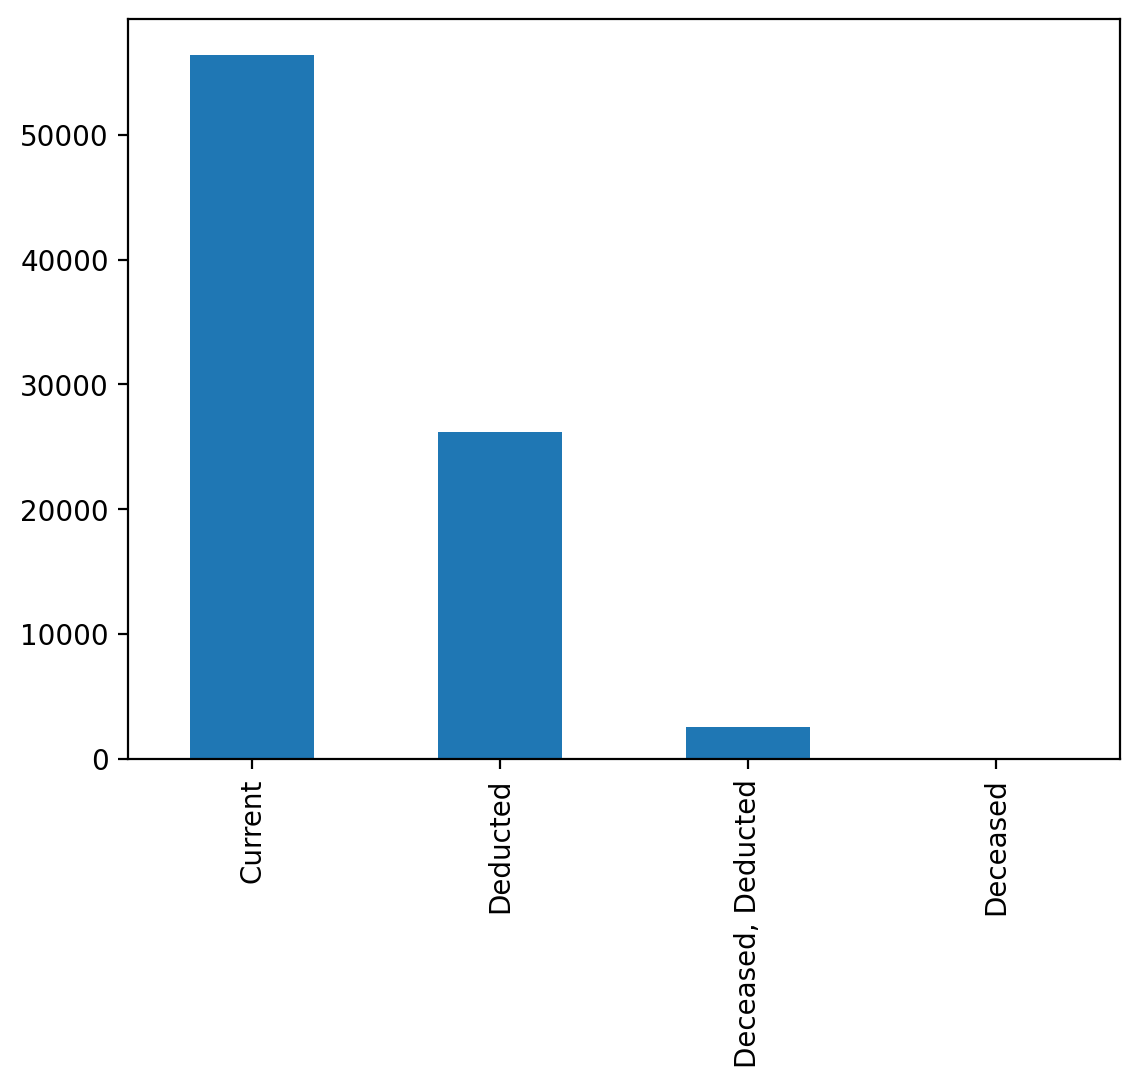

In [31]:
newdata['Registration status'].value_counts().plot(kind='bar')

In [32]:
newdata.to_csv(f'{OUTPUT_DATA}FULL_DISEASE_REGISTER.csv', index=False)

In [33]:
newdata.isna().sum()

NHS number             0
Patient ID             0
Postcode               0
Sex                    0
Registration date      0
Ethnicity category     0
Language               0
Registration status    0
FRAILTY                0
DEPRESSION             0
OBESITY                0
IHD                    0
DM                     0
HPT                    0
NDHG                   0
SMI                    0
Latitude               0
Longitude              0
IMD2023                0
dist_to_station        0
distance_from_surg     0
Age in years_y         0
dtype: int64

<Axes: xlabel='OBESITY', ylabel='Count'>

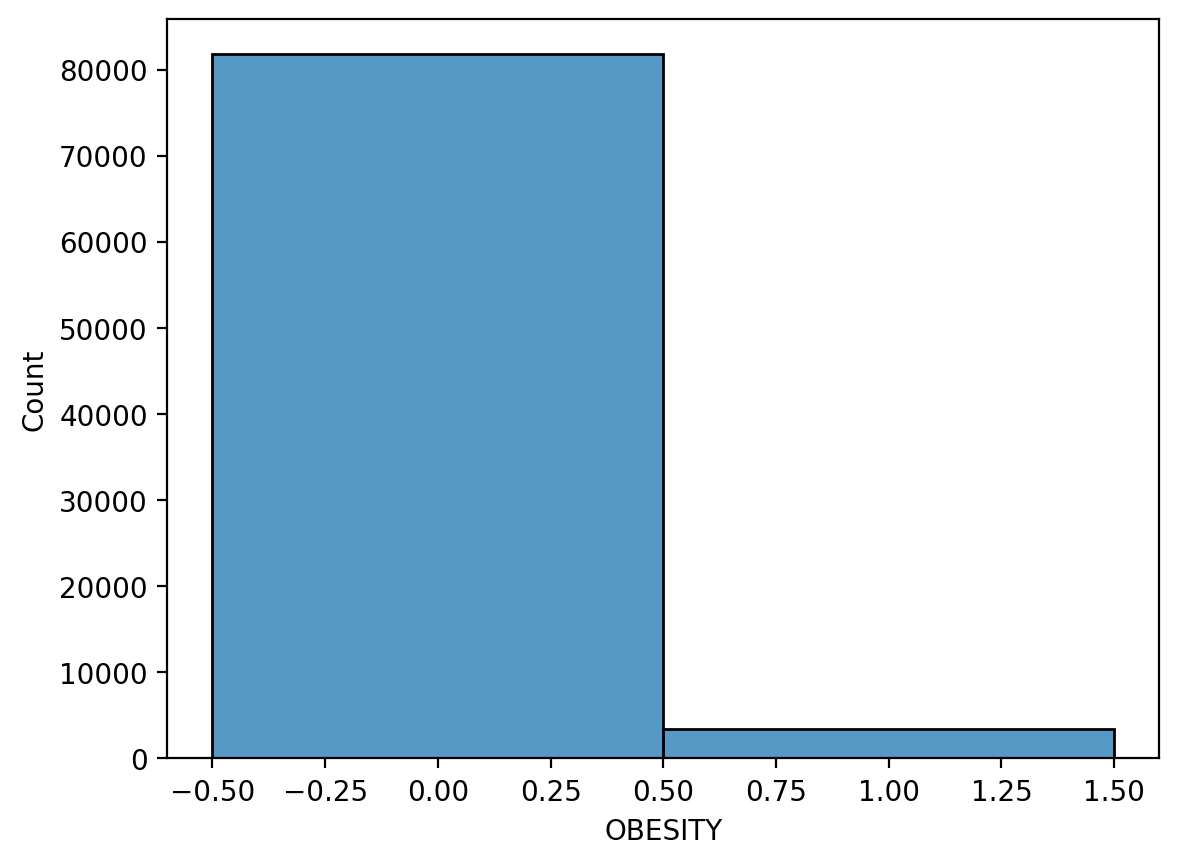

In [34]:
sns.histplot(data=newdata, x='OBESITY')

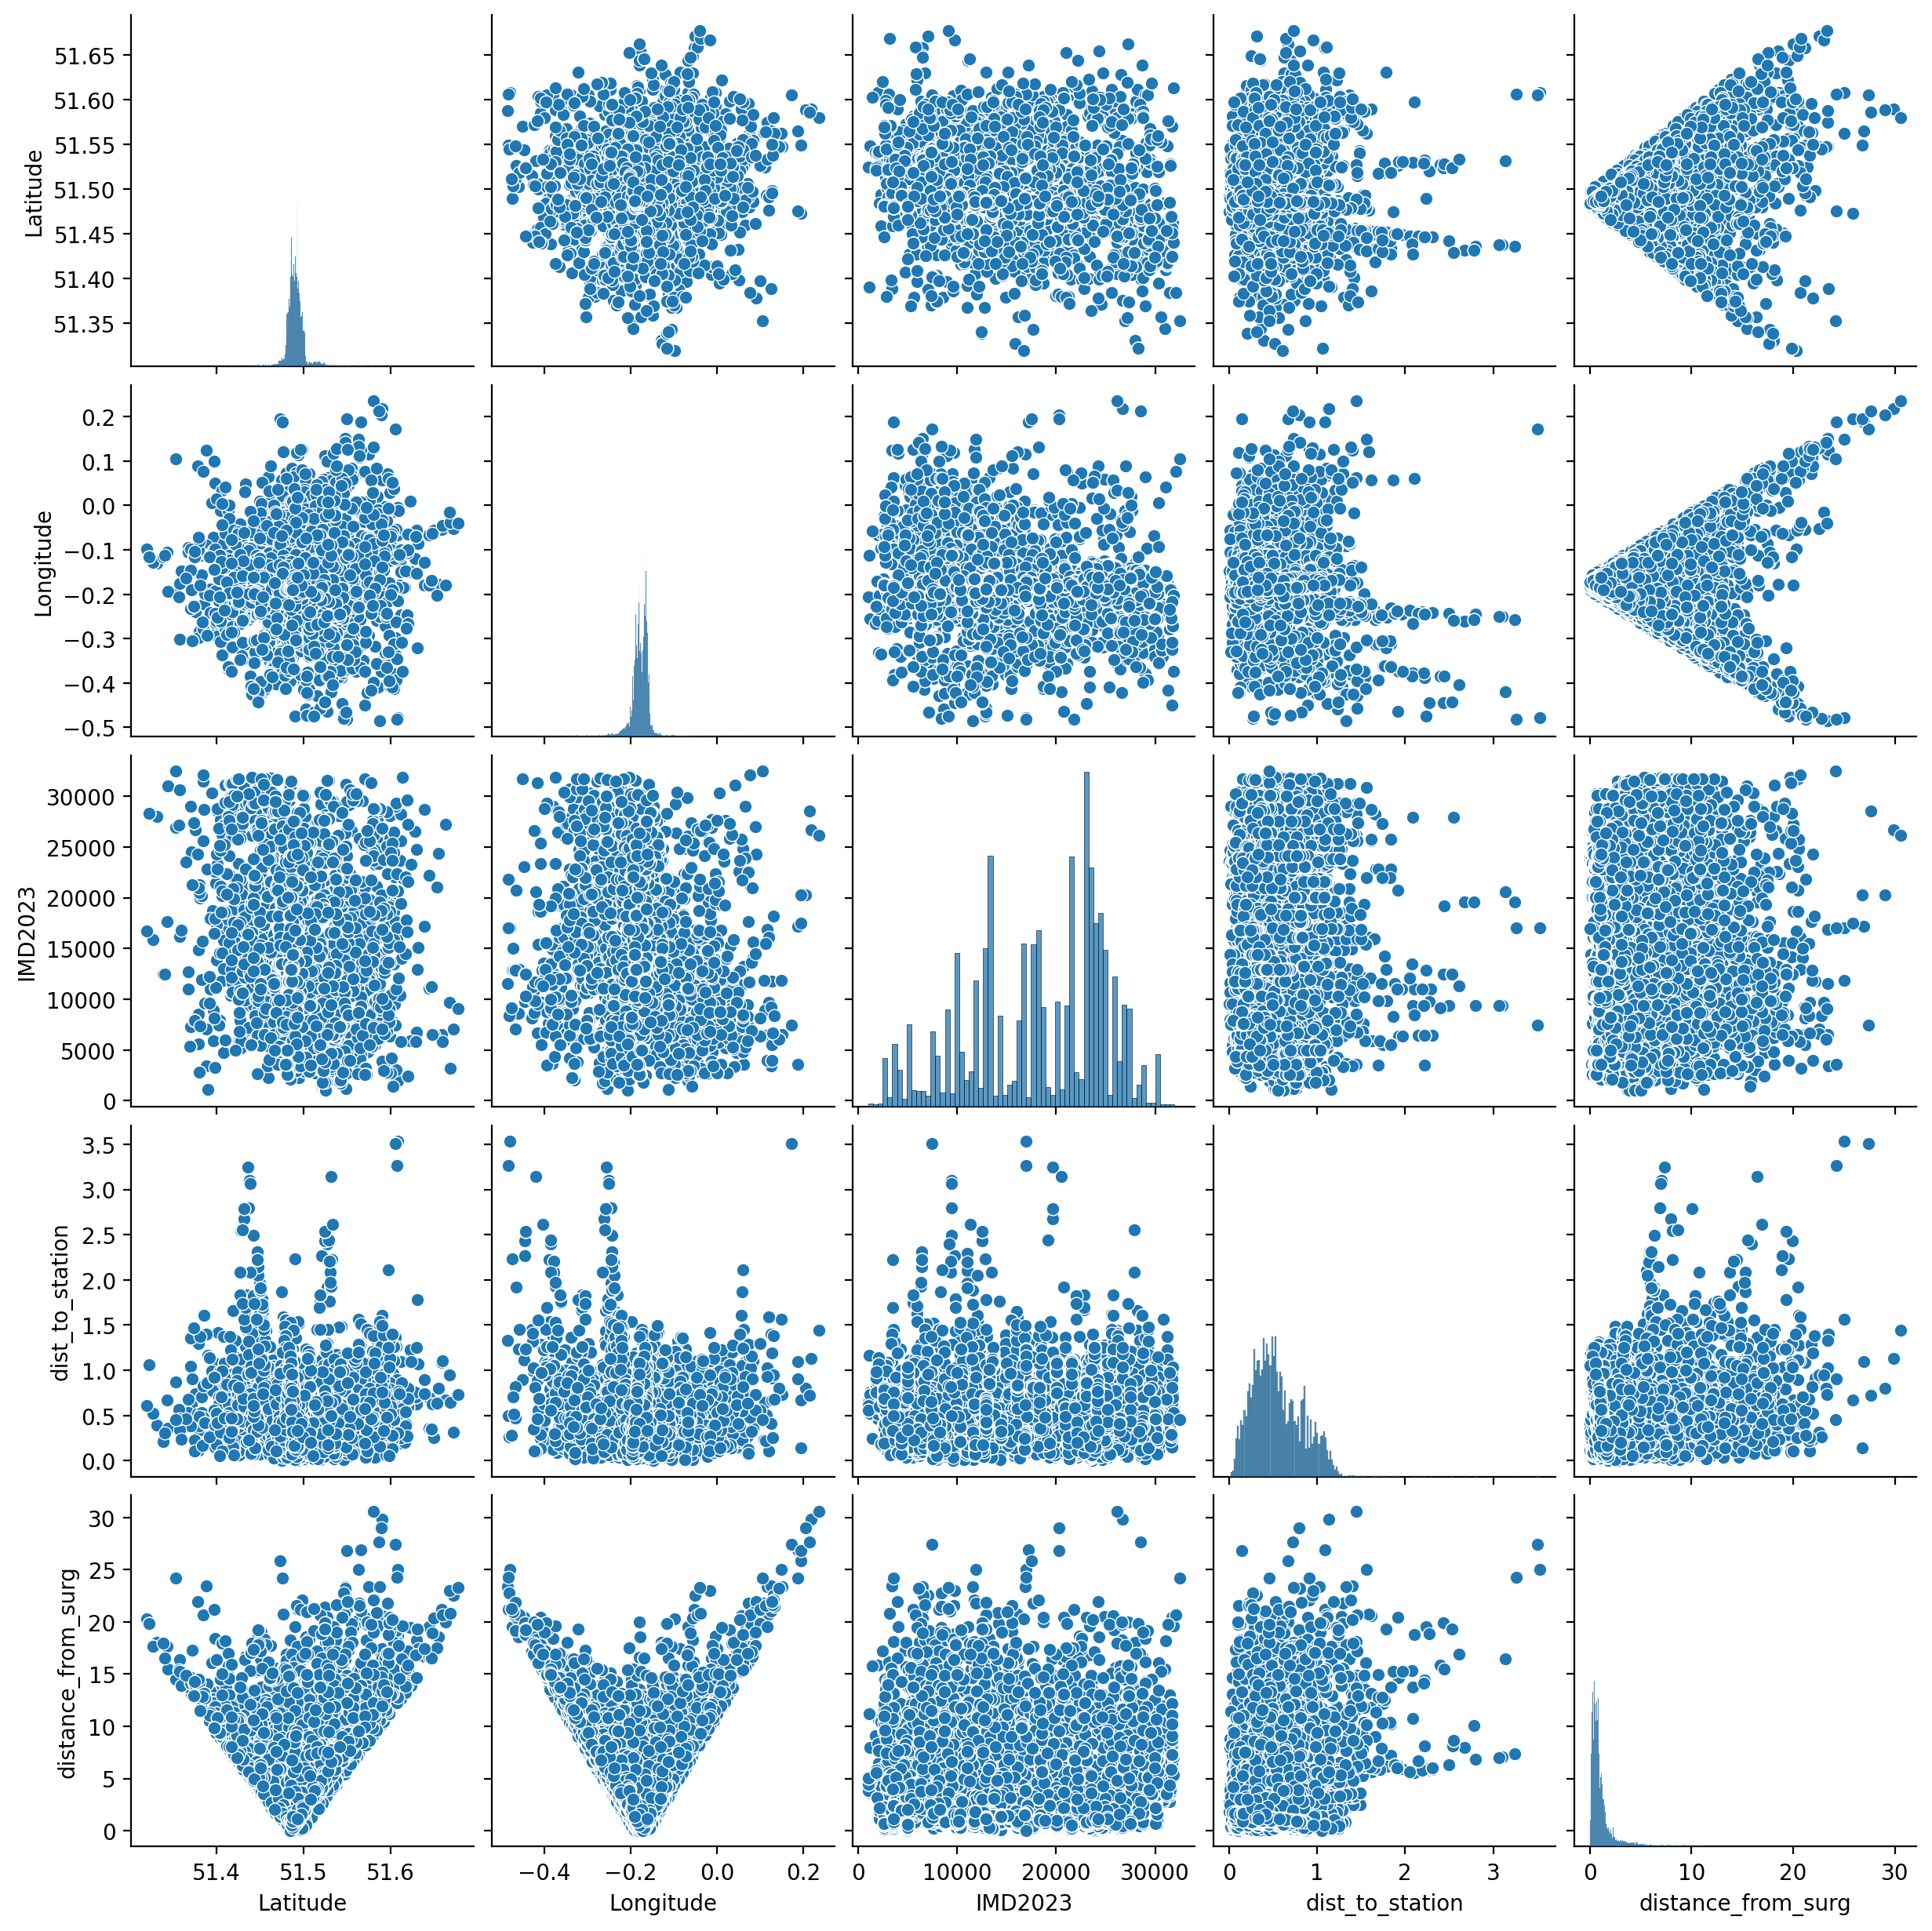

In [35]:
sns.pairplot(newdata)

In [43]:
allapps = pd.read_csv(f'{OUTPUT_DATA}global_apps_list.csv', dtype='str')

In [44]:
allapps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877467 entries, 0 to 877466
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Appointment booked date  877467 non-null  object
 1   Appointment date         877467 non-null  object
 2   Appointment status       877467 non-null  object
 3   Appointment time         877467 non-null  object
 4   Booked by                877467 non-null  object
 5   Clinician                877467 non-null  object
 6   Rota type                877467 non-null  object
 7   Patient ID               877467 non-null  object
dtypes: object(8)
memory usage: 53.6+ MB


In [45]:
fulldf = allapps.merge(newdata, on='Patient ID', how='left')

In [46]:
fulldf

,Appointment booked date,Appointment date,Appointment status,Appointment time,Booked by,Clinician,Rota type,Patient ID,NHS number,Postcode,Sex,Registration date,Ethnicity category,Language,Registration status,FRAILTY,DEPRESSION,OBESITY,IHD,DM,HPT,NDHG,SMI,Latitude,Longitude,IMD2023,dist_to_station,distance_from_surg,Age in years_y
0,10-May-22,14-Jul-22,Finished,10:00 - 10:59,"FLORKO, Aleksandra (Miss)","FLORKO, Aleksandra (Miss)",Earls Court Surgery Registrar,19581842,4446444913,SW5 9BY,Male,2009-08-17 00:00:00,Other Mixed,(XaG5t) Main spoken language English,"Deceased, Deducted",0,0,0,0,0,0,0,0,51.490204,-0.193625,16808.0,0.136631,0.204712,73
1,10-May-22,14-Jul-22,Finished,10:00 - 10:59,"FLORKO, Aleksandra (Miss)","FLORKO, Aleksandra (Miss)",Earls Court Surgery Registrar,19581842,4446444913,SW5 9BY,Male,2009-08-17 00:00:00,Other,(XaG5t) Main spoken language English,"Deceased, Deducted",0,0,0,0,0,0,0,0,51.490204,-0.193625,16808.0,0.136631,0.204712,73
2,10-May-22,14-Jul-22,Finished,10:00 - 10:59,"FLORKO, Aleksandra (Miss)","FLORKO, Aleksandra (Miss)",Earls Court Surgery Registrar,19581842,4446444913,SW5 9BY,Male,2009-08-17 00:00:00,British or Mixed British,(XaG5t) Main spoken language English,"Deceased, Deducted",0,0,0,0,0,0,0,0,51.490204,-0.193625,16808.0,0.136631,0.204712,73
3,12-May-22,05-Jul-22,Finished,09:00 - 09:59,"FLORKO, Aleksandra (Miss)","FLORKO, Aleksandra (Miss)",Earls Court Surgery Nurse,19580589,7066470737,W8 6JQ,Female,2014-01-07 00:00:00,Other White,(XaG62) Main spoken language Portuguese,Current,0,0,0,0,0,0,0,0,51.496001,-0.193468,22698.0,0.519419,0.816996,40
4,17-May-22,05-Jul-22,Finished,10:00 - 10:59,"LE TELLIER, Jean-Pierre","FLORKO, Aleksandra (Miss)",Earls Court Surgery Nurse,47551135,6284737955,SW3 3SQ,Male,2017-03-06 00:00:00,Indian or British Indian,(XaG5t) Main spoken language English,Current,0.39,0,1,0,1,1,0,0,51.490771,-0.168178,10169.0,0.540792,1.656309,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239811,31-Dec-19,31-Dec-19,Finished,15:00 - 15:59,"AMADI, Kasi (Miss)","PATEL, Rinku (Pharmacist)",Redcliffe Pharmacist,47490926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1239812,31-Dec-19,31-Dec-19,Finished,15:00 - 15:59,"AMADI, Kasi (Miss)","PATEL, Rinku (Pharmacist)",Redcliffe Pharmacist,47493202,4430687978,SW5 0DY,Male,2012-05-02 00:00:00,British or Mixed British,(XaG5t) Main spoken language English,Current,0.06,0,0,0,1,0,0,0,51.489257,-0.189864,14414.0,0.386273,1.348580,36
1239813,31-Dec-19,31-Dec-19,Finished,15:00 - 15:59,"AMADI, Kasi (Miss)","PATEL, Rinku (Pharmacist)",Redcliffe Pharmacist,47487575,6301037596,SW10 9AL,Female,2011-02-10 00:00:00,Chinese,(XaG5t) Main spoken language English,Current,0.08,0,0,0,0,0,0,0,51.488467,-0.191806,14414.0,0.287596,1.445016,42
1239814,31-Dec-19,31-Dec-19,Finished,15:00 - 15:59,"DUFFIELD, Katie (Miss)","PATEL, Rinku (Pharmacist)",Redcliffe Pharmacist,47489391,6183603341,SW5 9BY,Female,1976-11-26 00:00:00,British or Mixed British,(XaG5t) Main spoken language English,Current,0.06,1,1,0,0,0,0,0,51.490204,-0.193625,16808.0,0.136631,1.629449,51


In [55]:
fulldf.to_csv('FULL_DAYAFRAME_no_weather.csv', index=False)

In [56]:
%pwd

'/Users/janduplessis/code/janduplessis883/project-showupforhealth/notebooks'

In [48]:
fulldf.isna().sum()

Appointment booked date         0
Appointment date                0
Appointment status              0
Appointment time                0
Booked by                       0
Clinician                       0
Rota type                       0
Patient ID                      0
NHS number                 136032
Postcode                   136032
Sex                        136032
Registration date          136032
Ethnicity category         136032
Language                   136032
Registration status        136032
FRAILTY                    136032
DEPRESSION                 136032
OBESITY                    136032
IHD                        136032
DM                         136032
HPT                        136032
NDHG                       136032
SMI                        136032
Latitude                   136032
Longitude                  136032
IMD2023                    136032
dist_to_station            136032
distance_from_surg         136032
Age in years_y             136032
dtype: int64

In [50]:
fulldf.shape

(1239816, 29)

In [51]:
fulldf.dropna(inplace=True)

In [52]:
fulldf.shape

(1103784, 29)

In [53]:
fulldf['Registration status'].value_counts()

Current               892332
Deducted              152436
Deceased, Deducted     58690
Deceased                 326
Name: Registration status, dtype: int64

In [57]:
fulldf['Rota type'].value_counts()

KMC GP                                       170502
Redcliffe GP                                 114886
Session                                      113071
Stanhope Mews GP                             100922
The Good Practice GP                          92502
The Chelsea Practice GP                       58266
Earls Court Surgery GP                        39598
Stanhope Mews Nurse                           32682
KMC Nurse                                     25074
GP Session                                    21214
Redcliffe Nurse                               19879
Redcliffe Pharmacist                          18496
KMC Pharmacist                                17410
Health Partners at VM GP                      13966
Redcliffe Registrar                           13673
Stanhope Mews Nurse Practitioner              12940
Redcliffe HCA                                 12672
Earls Court Surgery Pharmacist                12604
HCA Session                                   11091
The Chelsea 